In [1]:
import os, json
import numpy as np
import models
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from engine import train, validate, test
from dataset import ClevrPOCDataSet
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel

import pickle


/home/marjan/anaconda3/envs/clip/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_FOLDER_NAME = 'output-12000'
DATA_FOLDER = '/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen/' + DATA_FOLDER_NAME + '/incomplete'
ENVIRONMENT_FOLDER = '/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen/environment_constraints'

In [3]:

with open(os.path.join('/home/marjan/code/CLEVR-POC/clevr-poc-dataset-gen', 'data', 'properties.json'), encoding="utf-8") as f:
    properties = json.load(f)


key_properties_values = []
for key_property in properties:
    if key_property == 'regions':
        continue
    key_properties_values.extend(properties[key_property].keys())

total_labels_to_index = {k: v for v, k in enumerate(key_properties_values)}
total_labels_to_index


{'cube': 0,
 'sphere': 1,
 'cylinder': 2,
 'cone': 3,
 'gray': 4,
 'red': 5,
 'blue': 6,
 'green': 7,
 'brown': 8,
 'purple': 9,
 'cyan': 10,
 'yellow': 11,
 'rubber': 12,
 'metal': 13,
 'large': 14,
 'medium': 15,
 'small': 16}

In [4]:

matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#clip_model_path = "openai/clip-vit-base-patch32"
#clip_model, clip_preprocess = clip.load('ViT-B/32', device)


In [5]:
#intialize the model

clip_embedding_dim = 512
env_embedding_dim = 768
clip_model, final_classifier = models.model(requires_grad=False, 
                                      clip_model = clip_model,
                                      #checkpoint=clip_model_path,
                                      clip_embedding_dim=clip_embedding_dim,
                                      env_embedding_dim = env_embedding_dim,
                                      output_dim=len(total_labels_to_index))

clip_model.to(device)
final_classifier.to(device)

dropout = nn.Dropout(0.1) # ????

# learning parameters
lr = 0.001
epochs = 200
batch_size = 8
optimizer = optim.Adam(final_classifier.parameters(), lr=lr)
criterion = nn.BCELoss()
dropout = nn.Dropout(0.1)

validation_threshold = 0.5



In [6]:
# train dataset
train_data = ClevrPOCDataSet(DATA_FOLDER, 'training', total_labels_to_index, ENVIRONMENT_FOLDER)

# validation dataset
valid_data = ClevrPOCDataSet(DATA_FOLDER, 'validation', total_labels_to_index, ENVIRONMENT_FOLDER)

# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

print('a')

a


In [7]:
# start the training and validation
train_loss = []
valid_loss = []
valid_acc = []
best_validation_acc = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(final_classifier, clip_model, train_loader, optimizer, criterion, train_data, device, dropout, clip_preprocess)
    valid_epoch_loss, valid_epoch_acc = validate(final_classifier, clip_model, valid_loader, criterion, valid_data, device, dropout, clip_preprocess, validation_threshold)
    if best_validation_acc < valid_epoch_acc:
        best_validation_acc = valid_epoch_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': final_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_' + DATA_FOLDER_NAME + '.pth')

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    
    with open('outputs/train_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(train_loss, f)
    with open('outputs/val_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_loss, f)
    with open('outputs/val_acc_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_acc, f)        
     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')
    print(f'Val Acc: {valid_epoch_acc:.4f}')

Epoch 1 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.3960
Val Loss: 0.3583
Val Acc: 0.8412
Epoch 2 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3400
Val Loss: 0.3252
Val Acc: 0.8506
Epoch 3 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3157
Val Loss: 0.3077
Val Acc: 0.8604
Epoch 4 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3005
Val Loss: 0.2991
Val Acc: 0.8671
Epoch 5 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.42it/s]


Train Loss: 0.2895
Val Loss: 0.2960
Val Acc: 0.8671
Epoch 6 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.88it/s]


Train Loss: 0.2807
Val Loss: 0.3005
Val Acc: 0.8627
Epoch 7 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.2747
Val Loss: 0.2777
Val Acc: 0.8718
Epoch 8 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2681
Val Loss: 0.2746
Val Acc: 0.8792
Epoch 9 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.2631
Val Loss: 0.2702
Val Acc: 0.8831
Epoch 10 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.2587
Val Loss: 0.2660
Val Acc: 0.8816
Epoch 11 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2550
Val Loss: 0.2688
Val Acc: 0.8827
Epoch 12 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2513
Val Loss: 0.2628
Val Acc: 0.8831
Epoch 13 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.2486
Val Loss: 0.2567
Val Acc: 0.8855
Epoch 14 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.2456
Val Loss: 0.2544
Val Acc: 0.8894
Epoch 15 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.87it/s]


Train Loss: 0.2426
Val Loss: 0.2634
Val Acc: 0.8894
Epoch 16 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.73it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2403
Val Loss: 0.2565
Val Acc: 0.8804
Epoch 17 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2381
Val Loss: 0.2556
Val Acc: 0.8898
Epoch 18 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.2364
Val Loss: 0.2487
Val Acc: 0.8882
Epoch 19 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.2339
Val Loss: 0.2465
Val Acc: 0.8890
Epoch 20 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2322
Val Loss: 0.2443
Val Acc: 0.8898
Epoch 21 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.2309
Val Loss: 0.2458
Val Acc: 0.8886
Epoch 22 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2292
Val Loss: 0.2434
Val Acc: 0.8925
Epoch 23 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.2281
Val Loss: 0.2388
Val Acc: 0.8969
Epoch 24 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2264
Val Loss: 0.2425
Val Acc: 0.8922
Epoch 25 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.73it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.2250
Val Loss: 0.2394
Val Acc: 0.8953
Epoch 26 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.2239
Val Loss: 0.2365
Val Acc: 0.9027
Epoch 27 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.2225
Val Loss: 0.2389
Val Acc: 0.8933
Epoch 28 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2216
Val Loss: 0.2354
Val Acc: 0.8941
Epoch 29 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.2208
Val Loss: 0.2326
Val Acc: 0.8925
Epoch 30 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2192
Val Loss: 0.2338
Val Acc: 0.8969
Epoch 31 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2182
Val Loss: 0.2384
Val Acc: 0.8988
Epoch 32 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2165
Val Loss: 0.2349
Val Acc: 0.8910
Epoch 33 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.52it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.2166
Val Loss: 0.2366
Val Acc: 0.8984
Epoch 34 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.2158
Val Loss: 0.2353
Val Acc: 0.8969
Epoch 35 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.2149
Val Loss: 0.2268
Val Acc: 0.8973
Epoch 36 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:59<00:00, 12.54it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2145
Val Loss: 0.2302
Val Acc: 0.8988
Epoch 37 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2138
Val Loss: 0.2295
Val Acc: 0.8996
Epoch 38 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.2122
Val Loss: 0.2281
Val Acc: 0.9008
Epoch 39 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.2120
Val Loss: 0.2270
Val Acc: 0.8937
Epoch 40 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2116
Val Loss: 0.2346
Val Acc: 0.8980
Epoch 41 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2105
Val Loss: 0.2257
Val Acc: 0.8969
Epoch 42 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.2093
Val Loss: 0.2311
Val Acc: 0.8941
Epoch 43 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.2107
Val Loss: 0.2298
Val Acc: 0.9043
Epoch 44 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.2085
Val Loss: 0.2270
Val Acc: 0.8976
Epoch 45 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2087
Val Loss: 0.2235
Val Acc: 0.8902
Epoch 46 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2077
Val Loss: 0.2271
Val Acc: 0.8941
Epoch 47 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2069
Val Loss: 0.2270
Val Acc: 0.8957
Epoch 48 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.2072
Val Loss: 0.2253
Val Acc: 0.8992
Epoch 49 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.2056
Val Loss: 0.2211
Val Acc: 0.8937
Epoch 50 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.2055
Val Loss: 0.2269
Val Acc: 0.8933
Epoch 51 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.87it/s]


Train Loss: 0.2056
Val Loss: 0.2248
Val Acc: 0.9012
Epoch 52 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.2050
Val Loss: 0.2272
Val Acc: 0.9027
Epoch 53 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2046
Val Loss: 0.2201
Val Acc: 0.9035
Epoch 54 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2039
Val Loss: 0.2205
Val Acc: 0.8933
Epoch 55 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2038
Val Loss: 0.2309
Val Acc: 0.8973
Epoch 56 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.2020
Val Loss: 0.2196
Val Acc: 0.9012
Epoch 57 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.2021
Val Loss: 0.2250
Val Acc: 0.8965
Epoch 58 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 12.41it/s]


Train Loss: 0.2020
Val Loss: 0.2228
Val Acc: 0.8949
Epoch 59 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.94it/s]


Train Loss: 0.2026
Val Loss: 0.2211
Val Acc: 0.9020
Epoch 60 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2016
Val Loss: 0.2230
Val Acc: 0.8980
Epoch 61 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.2007
Val Loss: 0.2240
Val Acc: 0.8922
Epoch 62 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.2003
Val Loss: 0.2207
Val Acc: 0.9035
Epoch 63 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.2011
Val Loss: 0.2202
Val Acc: 0.9055
Epoch 64 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.1999
Val Loss: 0.2218
Val Acc: 0.8973
Epoch 65 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.60it/s]


Train Loss: 0.1995
Val Loss: 0.2199
Val Acc: 0.9078
Epoch 66 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.1990
Val Loss: 0.2200
Val Acc: 0.9024
Epoch 67 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.87it/s]


Train Loss: 0.1989
Val Loss: 0.2204
Val Acc: 0.8965
Epoch 68 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1993
Val Loss: 0.2240
Val Acc: 0.8890
Epoch 69 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.1986
Val Loss: 0.2192
Val Acc: 0.9051
Epoch 70 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1985
Val Loss: 0.2195
Val Acc: 0.9031
Epoch 71 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1980
Val Loss: 0.2184
Val Acc: 0.9012
Epoch 72 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1977
Val Loss: 0.2169
Val Acc: 0.8996
Epoch 73 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.87it/s]


Train Loss: 0.1968
Val Loss: 0.2171
Val Acc: 0.9071
Epoch 74 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.1969
Val Loss: 0.2203
Val Acc: 0.9000
Epoch 75 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.68it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.1976
Val Loss: 0.2155
Val Acc: 0.9027
Epoch 76 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1960
Val Loss: 0.2192
Val Acc: 0.9004
Epoch 77 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.1957
Val Loss: 0.2195
Val Acc: 0.9004
Epoch 78 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.83it/s]


Train Loss: 0.1969
Val Loss: 0.2183
Val Acc: 0.9016
Epoch 79 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.1961
Val Loss: 0.2161
Val Acc: 0.8996
Epoch 80 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1951
Val Loss: 0.2161
Val Acc: 0.9055
Epoch 81 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.71it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.85it/s]


Train Loss: 0.1960
Val Loss: 0.2203
Val Acc: 0.8957
Epoch 82 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.1947
Val Loss: 0.2161
Val Acc: 0.9059
Epoch 83 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.69it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.84it/s]


Train Loss: 0.1939
Val Loss: 0.2122
Val Acc: 0.9051
Epoch 84 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.70it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1945
Val Loss: 0.2207
Val Acc: 0.8973
Epoch 85 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:57<00:00, 12.72it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.1936
Val Loss: 0.2178
Val Acc: 0.9031
Epoch 86 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:58<00:00, 12.67it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.86it/s]


Train Loss: 0.1940
Val Loss: 0.2122
Val Acc: 0.9031
Epoch 87 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1928
Val Loss: 0.2147
Val Acc: 0.9027
Epoch 88 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.92it/s]


Train Loss: 0.1935
Val Loss: 0.2223
Val Acc: 0.9027
Epoch 89 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.96it/s]


Train Loss: 0.1936
Val Loss: 0.2150
Val Acc: 0.9051
Epoch 90 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1933
Val Loss: 0.2152
Val Acc: 0.9043
Epoch 91 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.89it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1928
Val Loss: 0.2193
Val Acc: 0.9012
Epoch 92 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1927
Val Loss: 0.2222
Val Acc: 0.8969
Epoch 93 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.89it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1927
Val Loss: 0.2127
Val Acc: 0.9086
Epoch 94 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1931
Val Loss: 0.2136
Val Acc: 0.8976
Epoch 95 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1919
Val Loss: 0.2118
Val Acc: 0.8988
Epoch 96 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1921
Val Loss: 0.2146
Val Acc: 0.9059
Epoch 97 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1920
Val Loss: 0.2121
Val Acc: 0.9098
Epoch 98 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.09it/s]


Train Loss: 0.1906
Val Loss: 0.2148
Val Acc: 0.9004
Epoch 99 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.10it/s]


Train Loss: 0.1909
Val Loss: 0.2200
Val Acc: 0.9016
Epoch 100 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1896
Val Loss: 0.2142
Val Acc: 0.9098
Epoch 101 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1897
Val Loss: 0.2109
Val Acc: 0.9047
Epoch 102 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1904
Val Loss: 0.2133
Val Acc: 0.8988
Epoch 103 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1908
Val Loss: 0.2106
Val Acc: 0.9051
Epoch 104 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1912
Val Loss: 0.2270
Val Acc: 0.8949
Epoch 105 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.06it/s]


Train Loss: 0.1907
Val Loss: 0.2158
Val Acc: 0.9000
Epoch 106 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1905
Val Loss: 0.2127
Val Acc: 0.9035
Epoch 107 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1897
Val Loss: 0.2123
Val Acc: 0.8984
Epoch 108 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1895
Val Loss: 0.2162
Val Acc: 0.8996
Epoch 109 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.06it/s]


Train Loss: 0.1899
Val Loss: 0.2168
Val Acc: 0.8976
Epoch 110 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.86it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1895
Val Loss: 0.2189
Val Acc: 0.9024
Epoch 111 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1901
Val Loss: 0.2120
Val Acc: 0.9059
Epoch 112 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1890
Val Loss: 0.2099
Val Acc: 0.8980
Epoch 113 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.97it/s]


Train Loss: 0.1884
Val Loss: 0.2169
Val Acc: 0.9027
Epoch 114 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.91it/s]


Train Loss: 0.1895
Val Loss: 0.2177
Val Acc: 0.9051
Epoch 115 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1894
Val Loss: 0.2078
Val Acc: 0.9016
Epoch 116 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1888
Val Loss: 0.2093
Val Acc: 0.9078
Epoch 117 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1885
Val Loss: 0.2093
Val Acc: 0.9039
Epoch 118 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1881
Val Loss: 0.2107
Val Acc: 0.9078
Epoch 119 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1888
Val Loss: 0.2153
Val Acc: 0.9059
Epoch 120 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.96it/s]


Train Loss: 0.1876
Val Loss: 0.2125
Val Acc: 0.9031
Epoch 121 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.1880
Val Loss: 0.2140
Val Acc: 0.9020
Epoch 122 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1878
Val Loss: 0.2206
Val Acc: 0.9027
Epoch 123 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1874
Val Loss: 0.2126
Val Acc: 0.9071
Epoch 124 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1878
Val Loss: 0.2202
Val Acc: 0.8910
Epoch 125 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1871
Val Loss: 0.2109
Val Acc: 0.8953
Epoch 126 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1882
Val Loss: 0.2120
Val Acc: 0.9008
Epoch 127 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1871
Val Loss: 0.2081
Val Acc: 0.8957
Epoch 128 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.90it/s]


Train Loss: 0.1870
Val Loss: 0.2099
Val Acc: 0.8992
Epoch 129 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1875
Val Loss: 0.2111
Val Acc: 0.9039
Epoch 130 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1874
Val Loss: 0.2103
Val Acc: 0.9047
Epoch 131 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1870
Val Loss: 0.2084
Val Acc: 0.9071
Epoch 132 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1882
Val Loss: 0.2085
Val Acc: 0.9012
Epoch 133 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1864
Val Loss: 0.2108
Val Acc: 0.8965
Epoch 134 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1867
Val Loss: 0.2063
Val Acc: 0.9020
Epoch 135 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1864
Val Loss: 0.2106
Val Acc: 0.8969
Epoch 136 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.99it/s]


Train Loss: 0.1863
Val Loss: 0.2094
Val Acc: 0.9012
Epoch 137 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1863
Val Loss: 0.2096
Val Acc: 0.9024
Epoch 138 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1859
Val Loss: 0.2128
Val Acc: 0.9075
Epoch 139 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1866
Val Loss: 0.2062
Val Acc: 0.9067
Epoch 140 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1862
Val Loss: 0.2127
Val Acc: 0.9051
Epoch 141 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.09it/s]


Train Loss: 0.1860
Val Loss: 0.2086
Val Acc: 0.9063
Epoch 142 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1855
Val Loss: 0.2064
Val Acc: 0.9059
Epoch 143 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.06it/s]


Train Loss: 0.1848
Val Loss: 0.2111
Val Acc: 0.9043
Epoch 144 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1858
Val Loss: 0.2068
Val Acc: 0.9114
Epoch 145 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1858
Val Loss: 0.2111
Val Acc: 0.8996
Epoch 146 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1848
Val Loss: 0.2092
Val Acc: 0.9063
Epoch 147 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1854
Val Loss: 0.2045
Val Acc: 0.8984
Epoch 148 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1857
Val Loss: 0.2109
Val Acc: 0.9031
Epoch 149 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1856
Val Loss: 0.2093
Val Acc: 0.9071
Epoch 150 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.95it/s]


Train Loss: 0.1847
Val Loss: 0.2129
Val Acc: 0.9035
Epoch 151 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1847
Val Loss: 0.2102
Val Acc: 0.9051
Epoch 152 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1855
Val Loss: 0.2151
Val Acc: 0.9024
Epoch 153 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1859
Val Loss: 0.2057
Val Acc: 0.9020
Epoch 154 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1843
Val Loss: 0.2062
Val Acc: 0.9075
Epoch 155 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1844
Val Loss: 0.2066
Val Acc: 0.9043
Epoch 156 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.12it/s]


Train Loss: 0.1841
Val Loss: 0.2032
Val Acc: 0.9071
Epoch 157 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1846
Val Loss: 0.2084
Val Acc: 0.9047
Epoch 158 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1846
Val Loss: 0.2088
Val Acc: 0.9063
Epoch 159 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1847
Val Loss: 0.2081
Val Acc: 0.9047
Epoch 160 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1841
Val Loss: 0.2090
Val Acc: 0.8992
Epoch 161 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.82it/s]


Train Loss: 0.1835
Val Loss: 0.2075
Val Acc: 0.9035
Epoch 162 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1839
Val Loss: 0.2102
Val Acc: 0.8969
Epoch 163 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1841
Val Loss: 0.2077
Val Acc: 0.9039
Epoch 164 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1835
Val Loss: 0.2128
Val Acc: 0.9051
Epoch 165 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1825
Val Loss: 0.2096
Val Acc: 0.9039
Epoch 166 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.89it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1826
Val Loss: 0.2158
Val Acc: 0.9020
Epoch 167 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1827
Val Loss: 0.2075
Val Acc: 0.9020
Epoch 168 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.84it/s]


Train Loss: 0.1834
Val Loss: 0.2100
Val Acc: 0.8969
Epoch 169 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1841
Val Loss: 0.2120
Val Acc: 0.9086
Epoch 170 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1832
Val Loss: 0.2067
Val Acc: 0.9016
Epoch 171 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1830
Val Loss: 0.2087
Val Acc: 0.9063
Epoch 172 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.99it/s]


Train Loss: 0.1838
Val Loss: 0.2191
Val Acc: 0.9051
Epoch 173 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1831
Val Loss: 0.2094
Val Acc: 0.9012
Epoch 174 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1831
Val Loss: 0.2030
Val Acc: 0.9016
Epoch 175 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1842
Val Loss: 0.2082
Val Acc: 0.9059
Epoch 176 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1828
Val Loss: 0.2133
Val Acc: 0.8992
Epoch 177 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1821
Val Loss: 0.2097
Val Acc: 0.8961
Epoch 178 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1830
Val Loss: 0.2084
Val Acc: 0.9071
Epoch 179 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1820
Val Loss: 0.2113
Val Acc: 0.9043
Epoch 180 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.01it/s]


Train Loss: 0.1829
Val Loss: 0.2155
Val Acc: 0.9016
Epoch 181 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1822
Val Loss: 0.2069
Val Acc: 0.9110
Epoch 182 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1810
Val Loss: 0.2040
Val Acc: 0.9075
Epoch 183 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.06it/s]


Train Loss: 0.1821
Val Loss: 0.2052
Val Acc: 0.9067
Epoch 184 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1824
Val Loss: 0.2104
Val Acc: 0.9043
Epoch 185 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1827
Val Loss: 0.2061
Val Acc: 0.9035
Epoch 186 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.97it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.03it/s]


Train Loss: 0.1814
Val Loss: 0.2037
Val Acc: 0.8988
Epoch 187 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1817
Val Loss: 0.2054
Val Acc: 0.9063
Epoch 188 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1812
Val Loss: 0.2161
Val Acc: 0.8941
Epoch 189 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.96it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1822
Val Loss: 0.2047
Val Acc: 0.9059
Epoch 190 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1821
Val Loss: 0.2106
Val Acc: 0.9024
Epoch 191 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.04it/s]


Train Loss: 0.1821
Val Loss: 0.2074
Val Acc: 0.9067
Epoch 192 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.97it/s]


Train Loss: 0.1815
Val Loss: 0.2037
Val Acc: 0.9016
Epoch 193 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.07it/s]


Train Loss: 0.1828
Val Loss: 0.2096
Val Acc: 0.9020
Epoch 194 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.05it/s]


Train Loss: 0.1827
Val Loss: 0.2041
Val Acc: 0.9149
Epoch 195 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.95it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]


Train Loss: 0.1818
Val Loss: 0.2055
Val Acc: 0.9055
Epoch 196 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 12.94it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.98it/s]


Train Loss: 0.1812
Val Loss: 0.2052
Val Acc: 0.9086
Epoch 197 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.88it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.06it/s]


Train Loss: 0.1809
Val Loss: 0.2025
Val Acc: 0.9106
Epoch 198 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.92it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.00it/s]


Train Loss: 0.1811
Val Loss: 0.2123
Val Acc: 0.8980
Epoch 199 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.91it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.02it/s]


Train Loss: 0.1829
Val Loss: 0.2092
Val Acc: 0.8961
Epoch 200 of 200
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:56<00:00, 12.93it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 13.08it/s]

Train Loss: 0.1809
Val Loss: 0.2088
Val Acc: 0.9031


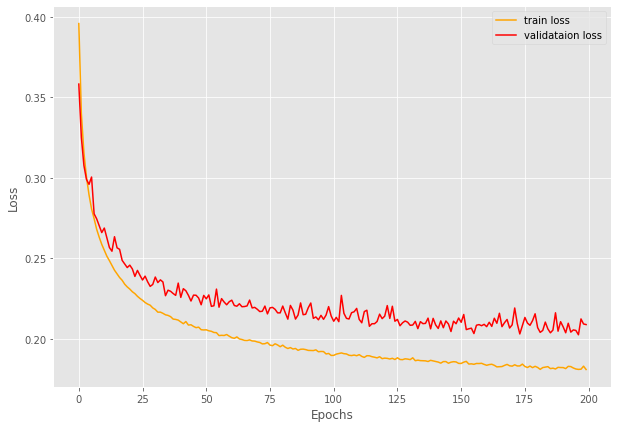

In [8]:
#torch.save({
#            'epoch': epochs,
#            'model_state_dict': final_classifier.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': criterion,
#            }, 'outputs/last_model_' + DATA_FOLDER_NAME + '.pth')


# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss_' + DATA_FOLDER_NAME + '.png')
plt.show()

In [9]:
checkpoint = torch.load('outputs/best_model_' + DATA_FOLDER_NAME + '.pth')
# load model weights state_dict
final_classifier.load_state_dict(checkpoint['model_state_dict'])

# test dataset
test_data = ClevrPOCDataSet(DATA_FOLDER, 'testing', total_labels_to_index, ENVIRONMENT_FOLDER)
# test data loader
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


test_exact_acc, test_partial_acc = test(final_classifier, clip_model, test_loader, criterion, test_data, device, dropout, clip_preprocess, validation_threshold)
print('test_exact_acc', test_exact_acc)
print('test_partial_acc', test_partial_acc)


Testing


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:21<00:00, 14.65it/s]

test_exact_acc 0.2816666666666667
test_partial_acc 0.9131862745098143


In [10]:
print(3)

3


In [ ]:
!pwd